In [1]:
try :
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False
print('IN COLAB: ', IN_COLAB)

IN COLAB:  True


In [2]:
import os
import pandas as pd

parentdir = "./propaganda_dataset_v2"
train_file= "propaganda_train.tsv"
val_file= "propaganda_val.tsv"

train_path=os.path.join(parentdir,train_file)
val_path=os.path.join(parentdir,val_file)

if IN_COLAB:
  train_path = '/content/propaganda_train.tsv'
  val_path = '/content/propaganda_val.tsv'

train_df=pd.read_csv(train_path,delimiter="\t",quotechar='|')
val_df=pd.read_csv(val_path,delimiter="\t",quotechar='|')
train_df = train_df.drop(train_df[train_df['label'] == 'not_propaganda'].index)
val_df = val_df.drop(val_df[val_df['label'] == 'not_propaganda'].index)
train_df
val_df


,label,tagged_in_context
1,causal_oversimplification,Mostly because <BOS> the country would not las...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....
4,repetition,It must be exacted from him directly in order ...
5,"name_calling,labeling",Is it any wonder that priests and laity alike ...
6,loaded_language,Health workers have been asked to work with co...
...,...,...
629,flag_waving,"As a result, 58,177 <BOS> Americans <EOS> woul..."
631,flag_waving,<BOS> But if you are a freedom-loving American...
632,loaded_language,I heard lots of <BOS> gut-wrenching stories <E...
638,flag_waving,<BOS> He also sang an Islamic State fight song...


In [3]:
import re
experiment = True

def extract_tagged_section(row):
    pattern = r'<BOS>.*?<EOS>'
    match = re.search(pattern, row['tagged_in_context'])
    return match.group() if match else ""

def extract_text_inside_tags(row):
    pattern = r'<BOS>(.*?)<EOS>'
    match = re.search(pattern, row['tagged_in_context'])
    return match.group(1).strip() if match else ""

def transform_multi_label(row):
    new_value = label_to_id[row['label']]
    return new_value

def transform_strip_tag(row):
    sent = row['tagged_in_context']
    cleaned_string = sent.replace("<BOS>", "")
    cleaned_string = cleaned_string.replace("<EOS>", "")
    return cleaned_string



label_to_id = {'flag_waving': 0, 'exaggeration,minimisation': 1, 'causal_oversimplification': 2, 'name_calling,labeling': 3, 'repetition': 4, 'doubt': 5, 'loaded_language': 6, 'appeal_to_fear_prejudice': 7}
id_to_label = {0: 'flag_waving', 1: 'exaggeration,minimisation', 2: 'causal_oversimplification', 3: 'name_calling,labeling', 4: 'repetition', 5: 'doubt',6: 'loaded_language', 7: 'appeal_to_fear_prejudice'}

train_df['label_str'] = train_df.apply(transform_multi_label, axis=1)
train_df['extract_no_tags'] = train_df.apply(extract_text_inside_tags, axis=1)
train_df['extract_with_tags'] = train_df.apply(extract_tagged_section, axis=1)

val_df['label_str'] = val_df.apply(transform_multi_label, axis=1)
val_df['extract_no_tags'] = val_df.apply(extract_text_inside_tags, axis=1)
val_df['extract_with_tags'] = val_df.apply(extract_tagged_section, axis=1)

val_df

,label,tagged_in_context,label_str,extract_no_tags,extract_with_tags
1,causal_oversimplification,Mostly because <BOS> the country would not las...,2,the country would not last long without an out...,<BOS> the country would not last long without ...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,7,gets Earl Warren and Sen. Richard Russel to jo...,<BOS> gets Earl Warren and Sen. Richard Russel...
4,repetition,It must be exacted from him directly in order ...,4,infidels,<BOS> infidels <EOS>
5,"name_calling,labeling",Is it any wonder that priests and laity alike ...,3,"the ""gay lifestyle","<BOS> the ""gay lifestyle <EOS>"
6,loaded_language,Health workers have been asked to work with co...,6,devastating communities,<BOS> devastating communities <EOS>
...,...,...,...,...,...
629,flag_waving,"As a result, 58,177 <BOS> Americans <EOS> woul...",0,Americans,<BOS> Americans <EOS>
631,flag_waving,<BOS> But if you are a freedom-loving American...,0,But if you are a freedom-loving American,<BOS> But if you are a freedom-loving American...
632,loaded_language,I heard lots of <BOS> gut-wrenching stories <E...,6,gut-wrenching stories,<BOS> gut-wrenching stories <EOS>
638,flag_waving,<BOS> He also sang an Islamic State fight song...,0,He also sang an Islamic State fight song and r...,<BOS> He also sang an Islamic State fight song...


In [4]:
# longest_string = val_df['extract_no_tags'].apply(lambda x: len(str(x))).max()
# print("Longest string length:", longest_string)

In [5]:
epochs = 24

batch_size=25
max_len=150
n_classes = 8

sent_col = 'extract_no_tags'
target_col = 'label_str'

# sent_col = 'extract_with_tags'

In [6]:
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer
import torch
import numpy as np



class CustomPropagandaDataset_vanilla(Dataset):
    def __init__(self,df, max_len, sent_col, target_col):
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        self.labels=torch.tensor([label for label in df[target_col]])
        # print(self.labels)
        self.texts=[tokenizer(text,padding='max_length',max_length=max_len,truncation=True,return_tensors="pt") for text in df[sent_col]]
        # print(self.texts)
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self,idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self,idx):
        return self.texts[idx]

    def __getitem__(self,idx):
        batch_texts=self.get_batch_texts(idx)
        batch_y=self.get_batch_labels(idx)

        return batch_texts,batch_y


def prepare_inputs(input1,label,device):
  label=label.to(device)
  mask=input1['attention_mask'].to(device)
  input_id=input1['input_ids'].squeeze(1).to(device)
  return (input_id,mask,label)

In [7]:
train_data = CustomPropagandaDataset_vanilla(train_df, max_len, sent_col, target_col)
val_data = CustomPropagandaDataset_vanilla(val_df, max_len, sent_col, target_col)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
val_dataloader=torch.utils.data.DataLoader(val_data,batch_size=batch_size)

In [9]:
from torch import nn

class BertClassifier(nn.Module):

    def __init__(self,dropout=0.5,num_classes=8):
        super(BertClassifier, self).__init__()

        self.bert=BertModel.from_pretrained('bert-base-uncased')
        self.dropout=nn.Dropout(dropout)
        self.linear=nn.Linear(768,num_classes)
        self.relu=nn.ReLU()

    def forward(self,input_id,mask):

        _, pooled_output = self.bert(input_ids=input_id,attention_mask=mask,return_dict=False)
        dropout_output=self.dropout(pooled_output)
        linear_output=self.linear(dropout_output)
        final_layer=self.relu(linear_output)

        return final_layer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 1 | Train Loss: 0.085 | Train Accuracy: 0.139
Val loss: 0.087 | Val Accuracy: 0.165


100%|██████████| 52/52 [00:16<00:00,  3.24it/s]


Epochs: 2 | Train Loss: 0.084 | Train Accuracy: 0.150
Val loss: 0.087 | Val Accuracy: 0.175


100%|██████████| 52/52 [00:15<00:00,  3.27it/s]


Epochs: 3 | Train Loss: 0.084 | Train Accuracy: 0.162
Val loss: 0.086 | Val Accuracy: 0.204


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 4 | Train Loss: 0.083 | Train Accuracy: 0.168
Val loss: 0.085 | Val Accuracy: 0.233


100%|██████████| 52/52 [00:15<00:00,  3.32it/s]


Epochs: 5 | Train Loss: 0.083 | Train Accuracy: 0.169
Val loss: 0.085 | Val Accuracy: 0.239


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 6 | Train Loss: 0.082 | Train Accuracy: 0.194
Val loss: 0.084 | Val Accuracy: 0.243


100%|██████████| 52/52 [00:15<00:00,  3.28it/s]


Epochs: 7 | Train Loss: 0.082 | Train Accuracy: 0.201
Val loss: 0.084 | Val Accuracy: 0.256


100%|██████████| 52/52 [00:15<00:00,  3.28it/s]


Epochs: 8 | Train Loss: 0.081 | Train Accuracy: 0.214
Val loss: 0.083 | Val Accuracy: 0.282


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 9 | Train Loss: 0.081 | Train Accuracy: 0.227
Val loss: 0.082 | Val Accuracy: 0.278


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 10 | Train Loss: 0.081 | Train Accuracy: 0.239
Val loss: 0.082 | Val Accuracy: 0.285


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 11 | Train Loss: 0.080 | Train Accuracy: 0.246
Val loss: 0.081 | Val Accuracy: 0.327


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 12 | Train Loss: 0.080 | Train Accuracy: 0.253
Val loss: 0.080 | Val Accuracy: 0.359


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 13 | Train Loss: 0.078 | Train Accuracy: 0.287
Val loss: 0.079 | Val Accuracy: 0.369


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 14 | Train Loss: 0.078 | Train Accuracy: 0.294
Val loss: 0.079 | Val Accuracy: 0.369


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 15 | Train Loss: 0.077 | Train Accuracy: 0.302
Val loss: 0.078 | Val Accuracy: 0.408


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 16 | Train Loss: 0.076 | Train Accuracy: 0.314
Val loss: 0.077 | Val Accuracy: 0.395


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 17 | Train Loss: 0.076 | Train Accuracy: 0.338
Val loss: 0.076 | Val Accuracy: 0.395


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 18 | Train Loss: 0.074 | Train Accuracy: 0.356
Val loss: 0.075 | Val Accuracy: 0.411


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 19 | Train Loss: 0.074 | Train Accuracy: 0.343
Val loss: 0.074 | Val Accuracy: 0.417


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 20 | Train Loss: 0.073 | Train Accuracy: 0.343
Val loss: 0.074 | Val Accuracy: 0.421


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 21 | Train Loss: 0.072 | Train Accuracy: 0.384
Val loss: 0.073 | Val Accuracy: 0.434


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 22 | Train Loss: 0.071 | Train Accuracy: 0.384
Val loss: 0.072 | Val Accuracy: 0.450


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 23 | Train Loss: 0.070 | Train Accuracy: 0.404
Val loss: 0.071 | Val Accuracy: 0.440


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 24 | Train Loss: 0.069 | Train Accuracy: 0.434
Val loss: 0.070 | Val Accuracy: 0.450


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 25 | Train Loss: 0.068 | Train Accuracy: 0.437
Val loss: 0.070 | Val Accuracy: 0.466


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 26 | Train Loss: 0.068 | Train Accuracy: 0.415
Val loss: 0.069 | Val Accuracy: 0.463


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 27 | Train Loss: 0.066 | Train Accuracy: 0.464
Val loss: 0.068 | Val Accuracy: 0.476


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 28 | Train Loss: 0.066 | Train Accuracy: 0.460
Val loss: 0.067 | Val Accuracy: 0.463


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 29 | Train Loss: 0.066 | Train Accuracy: 0.445
Val loss: 0.067 | Val Accuracy: 0.476


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 30 | Train Loss: 0.064 | Train Accuracy: 0.490
Val loss: 0.066 | Val Accuracy: 0.476


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 31 | Train Loss: 0.063 | Train Accuracy: 0.500
Val loss: 0.065 | Val Accuracy: 0.492


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 32 | Train Loss: 0.062 | Train Accuracy: 0.510
Val loss: 0.064 | Val Accuracy: 0.492


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 33 | Train Loss: 0.061 | Train Accuracy: 0.517
Val loss: 0.064 | Val Accuracy: 0.505


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 34 | Train Loss: 0.061 | Train Accuracy: 0.510
Val loss: 0.063 | Val Accuracy: 0.502


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 35 | Train Loss: 0.060 | Train Accuracy: 0.535
Val loss: 0.062 | Val Accuracy: 0.524


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 36 | Train Loss: 0.059 | Train Accuracy: 0.533
Val loss: 0.062 | Val Accuracy: 0.518


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 37 | Train Loss: 0.058 | Train Accuracy: 0.547
Val loss: 0.061 | Val Accuracy: 0.528


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 38 | Train Loss: 0.057 | Train Accuracy: 0.577
Val loss: 0.061 | Val Accuracy: 0.521


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 39 | Train Loss: 0.057 | Train Accuracy: 0.579
Val loss: 0.060 | Val Accuracy: 0.528


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 40 | Train Loss: 0.056 | Train Accuracy: 0.569
Val loss: 0.060 | Val Accuracy: 0.537


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 41 | Train Loss: 0.055 | Train Accuracy: 0.597
Val loss: 0.059 | Val Accuracy: 0.544


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 42 | Train Loss: 0.055 | Train Accuracy: 0.590
Val loss: 0.058 | Val Accuracy: 0.544


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 43 | Train Loss: 0.053 | Train Accuracy: 0.617
Val loss: 0.058 | Val Accuracy: 0.544


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 44 | Train Loss: 0.053 | Train Accuracy: 0.620
Val loss: 0.057 | Val Accuracy: 0.553


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 45 | Train Loss: 0.052 | Train Accuracy: 0.610
Val loss: 0.057 | Val Accuracy: 0.560


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 46 | Train Loss: 0.051 | Train Accuracy: 0.615
Val loss: 0.056 | Val Accuracy: 0.560


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 47 | Train Loss: 0.050 | Train Accuracy: 0.639
Val loss: 0.056 | Val Accuracy: 0.563


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 48 | Train Loss: 0.050 | Train Accuracy: 0.655
Val loss: 0.056 | Val Accuracy: 0.566


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 49 | Train Loss: 0.049 | Train Accuracy: 0.648
Val loss: 0.055 | Val Accuracy: 0.566


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 50 | Train Loss: 0.048 | Train Accuracy: 0.661
Val loss: 0.054 | Val Accuracy: 0.579


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 51 | Train Loss: 0.047 | Train Accuracy: 0.671
Val loss: 0.054 | Val Accuracy: 0.586


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 52 | Train Loss: 0.047 | Train Accuracy: 0.671
Val loss: 0.053 | Val Accuracy: 0.583


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 53 | Train Loss: 0.046 | Train Accuracy: 0.697
Val loss: 0.053 | Val Accuracy: 0.586


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 54 | Train Loss: 0.046 | Train Accuracy: 0.694
Val loss: 0.053 | Val Accuracy: 0.589


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 55 | Train Loss: 0.045 | Train Accuracy: 0.710
Val loss: 0.052 | Val Accuracy: 0.592


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 56 | Train Loss: 0.045 | Train Accuracy: 0.706
Val loss: 0.052 | Val Accuracy: 0.579


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 57 | Train Loss: 0.044 | Train Accuracy: 0.696
Val loss: 0.051 | Val Accuracy: 0.589


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 58 | Train Loss: 0.043 | Train Accuracy: 0.724
Val loss: 0.051 | Val Accuracy: 0.592


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 59 | Train Loss: 0.042 | Train Accuracy: 0.710
Val loss: 0.051 | Val Accuracy: 0.586


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 60 | Train Loss: 0.041 | Train Accuracy: 0.732
Val loss: 0.050 | Val Accuracy: 0.586
______ccb211a9-0347-40b8-b7da-b4c325af7a6d______
LR: 1e-06 FINAL ACC = 0.586
LR: 1e-06 BEST ACC = 0.592
____________


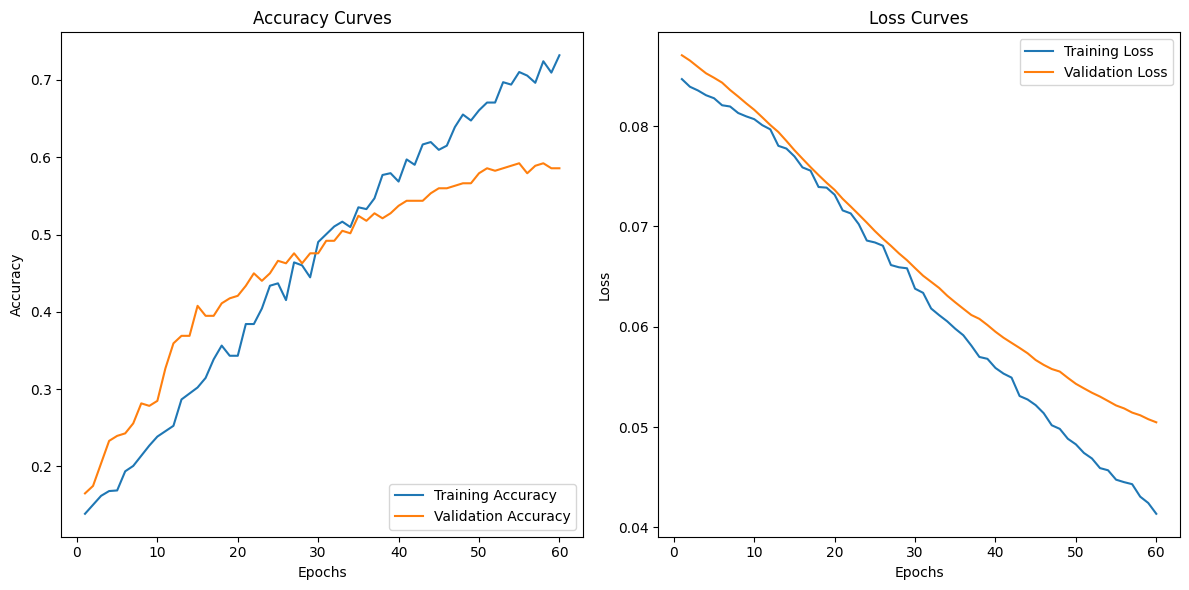

Classification Report:
                           precision    recall  f1-score   support

              flag_waving       0.68      0.76      0.72        45
exaggeration,minimisation       0.53      0.57      0.55        30
causal_oversimplification       0.52      0.69      0.59        35
    name_calling,labeling       0.68      0.88      0.77        34
               repetition       0.60      0.38      0.46        40
                    doubt       0.66      0.67      0.67        43
          loaded_language       0.56      0.59      0.57        39
 appeal_to_fear_prejudice       0.41      0.26      0.31        43

                 accuracy                           0.59       309
                macro avg       0.58      0.60      0.58       309
             weighted avg       0.58      0.59      0.58       309



100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 1 | Train Loss: 0.084 | Train Accuracy: 0.146
Val loss: 0.087 | Val Accuracy: 0.129


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 2 | Train Loss: 0.084 | Train Accuracy: 0.139
Val loss: 0.087 | Val Accuracy: 0.149


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 3 | Train Loss: 0.085 | Train Accuracy: 0.129
Val loss: 0.087 | Val Accuracy: 0.172


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 4 | Train Loss: 0.084 | Train Accuracy: 0.166
Val loss: 0.087 | Val Accuracy: 0.191


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 5 | Train Loss: 0.084 | Train Accuracy: 0.154
Val loss: 0.086 | Val Accuracy: 0.214


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 6 | Train Loss: 0.084 | Train Accuracy: 0.160
Val loss: 0.086 | Val Accuracy: 0.239


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 7 | Train Loss: 0.083 | Train Accuracy: 0.173
Val loss: 0.086 | Val Accuracy: 0.252


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 8 | Train Loss: 0.083 | Train Accuracy: 0.182
Val loss: 0.086 | Val Accuracy: 0.259


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 9 | Train Loss: 0.083 | Train Accuracy: 0.191
Val loss: 0.086 | Val Accuracy: 0.262


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 10 | Train Loss: 0.083 | Train Accuracy: 0.187
Val loss: 0.085 | Val Accuracy: 0.262


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 11 | Train Loss: 0.082 | Train Accuracy: 0.198
Val loss: 0.085 | Val Accuracy: 0.262


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 12 | Train Loss: 0.082 | Train Accuracy: 0.204
Val loss: 0.085 | Val Accuracy: 0.252


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 13 | Train Loss: 0.082 | Train Accuracy: 0.231
Val loss: 0.085 | Val Accuracy: 0.265


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 14 | Train Loss: 0.082 | Train Accuracy: 0.213
Val loss: 0.084 | Val Accuracy: 0.265


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 15 | Train Loss: 0.082 | Train Accuracy: 0.224
Val loss: 0.084 | Val Accuracy: 0.262


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 16 | Train Loss: 0.081 | Train Accuracy: 0.235
Val loss: 0.084 | Val Accuracy: 0.265


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 17 | Train Loss: 0.081 | Train Accuracy: 0.232
Val loss: 0.084 | Val Accuracy: 0.272


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 18 | Train Loss: 0.080 | Train Accuracy: 0.255
Val loss: 0.083 | Val Accuracy: 0.262


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 19 | Train Loss: 0.080 | Train Accuracy: 0.243
Val loss: 0.083 | Val Accuracy: 0.265


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 20 | Train Loss: 0.080 | Train Accuracy: 0.264
Val loss: 0.083 | Val Accuracy: 0.272


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 21 | Train Loss: 0.079 | Train Accuracy: 0.265
Val loss: 0.083 | Val Accuracy: 0.272


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 22 | Train Loss: 0.079 | Train Accuracy: 0.290
Val loss: 0.083 | Val Accuracy: 0.272


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 23 | Train Loss: 0.079 | Train Accuracy: 0.285
Val loss: 0.082 | Val Accuracy: 0.275


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 24 | Train Loss: 0.079 | Train Accuracy: 0.283
Val loss: 0.082 | Val Accuracy: 0.278


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 25 | Train Loss: 0.079 | Train Accuracy: 0.294
Val loss: 0.082 | Val Accuracy: 0.275


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 26 | Train Loss: 0.079 | Train Accuracy: 0.288
Val loss: 0.082 | Val Accuracy: 0.285


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 27 | Train Loss: 0.078 | Train Accuracy: 0.314
Val loss: 0.081 | Val Accuracy: 0.288


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 28 | Train Loss: 0.077 | Train Accuracy: 0.321
Val loss: 0.081 | Val Accuracy: 0.288


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 29 | Train Loss: 0.078 | Train Accuracy: 0.315
Val loss: 0.081 | Val Accuracy: 0.288


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 30 | Train Loss: 0.077 | Train Accuracy: 0.305
Val loss: 0.081 | Val Accuracy: 0.288


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 31 | Train Loss: 0.077 | Train Accuracy: 0.319
Val loss: 0.080 | Val Accuracy: 0.291


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 32 | Train Loss: 0.076 | Train Accuracy: 0.332
Val loss: 0.080 | Val Accuracy: 0.294


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 33 | Train Loss: 0.075 | Train Accuracy: 0.336
Val loss: 0.079 | Val Accuracy: 0.311


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 34 | Train Loss: 0.076 | Train Accuracy: 0.324
Val loss: 0.079 | Val Accuracy: 0.314


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 35 | Train Loss: 0.075 | Train Accuracy: 0.338
Val loss: 0.079 | Val Accuracy: 0.324


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 36 | Train Loss: 0.074 | Train Accuracy: 0.361
Val loss: 0.078 | Val Accuracy: 0.330


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 37 | Train Loss: 0.074 | Train Accuracy: 0.353
Val loss: 0.078 | Val Accuracy: 0.340


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 38 | Train Loss: 0.074 | Train Accuracy: 0.359
Val loss: 0.078 | Val Accuracy: 0.343


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 39 | Train Loss: 0.073 | Train Accuracy: 0.359
Val loss: 0.077 | Val Accuracy: 0.343


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 40 | Train Loss: 0.073 | Train Accuracy: 0.386
Val loss: 0.077 | Val Accuracy: 0.346


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 41 | Train Loss: 0.073 | Train Accuracy: 0.359
Val loss: 0.077 | Val Accuracy: 0.343


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 42 | Train Loss: 0.072 | Train Accuracy: 0.384
Val loss: 0.076 | Val Accuracy: 0.350


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 43 | Train Loss: 0.072 | Train Accuracy: 0.395
Val loss: 0.076 | Val Accuracy: 0.366


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 44 | Train Loss: 0.072 | Train Accuracy: 0.391
Val loss: 0.076 | Val Accuracy: 0.369


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 45 | Train Loss: 0.071 | Train Accuracy: 0.399
Val loss: 0.075 | Val Accuracy: 0.366


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 46 | Train Loss: 0.071 | Train Accuracy: 0.393
Val loss: 0.075 | Val Accuracy: 0.366


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 47 | Train Loss: 0.071 | Train Accuracy: 0.399
Val loss: 0.075 | Val Accuracy: 0.366


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 48 | Train Loss: 0.070 | Train Accuracy: 0.398
Val loss: 0.074 | Val Accuracy: 0.369


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 49 | Train Loss: 0.070 | Train Accuracy: 0.405
Val loss: 0.074 | Val Accuracy: 0.369


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 50 | Train Loss: 0.069 | Train Accuracy: 0.418
Val loss: 0.074 | Val Accuracy: 0.372


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 51 | Train Loss: 0.069 | Train Accuracy: 0.425
Val loss: 0.073 | Val Accuracy: 0.375


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 52 | Train Loss: 0.069 | Train Accuracy: 0.423
Val loss: 0.073 | Val Accuracy: 0.372


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 53 | Train Loss: 0.068 | Train Accuracy: 0.451
Val loss: 0.073 | Val Accuracy: 0.372


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 54 | Train Loss: 0.068 | Train Accuracy: 0.441
Val loss: 0.072 | Val Accuracy: 0.372


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 55 | Train Loss: 0.068 | Train Accuracy: 0.445
Val loss: 0.072 | Val Accuracy: 0.375


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 56 | Train Loss: 0.067 | Train Accuracy: 0.443
Val loss: 0.072 | Val Accuracy: 0.385


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 57 | Train Loss: 0.067 | Train Accuracy: 0.441
Val loss: 0.071 | Val Accuracy: 0.385


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 58 | Train Loss: 0.067 | Train Accuracy: 0.448
Val loss: 0.071 | Val Accuracy: 0.392


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 59 | Train Loss: 0.066 | Train Accuracy: 0.452
Val loss: 0.071 | Val Accuracy: 0.395


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 60 | Train Loss: 0.066 | Train Accuracy: 0.453
Val loss: 0.071 | Val Accuracy: 0.401
______f0e00455-29ff-4ad9-b89a-b465d56bc5e4______
LR: 5e-07 FINAL ACC = 0.401
LR: 5e-07 BEST ACC = 0.401
____________


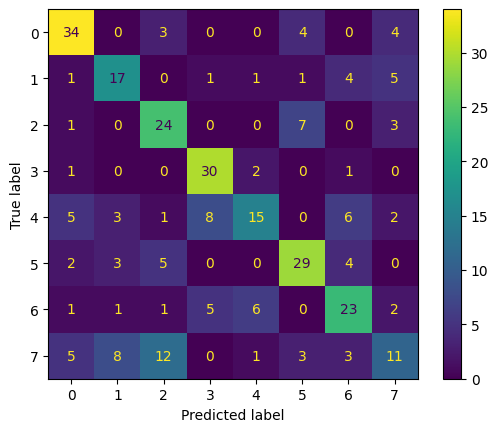

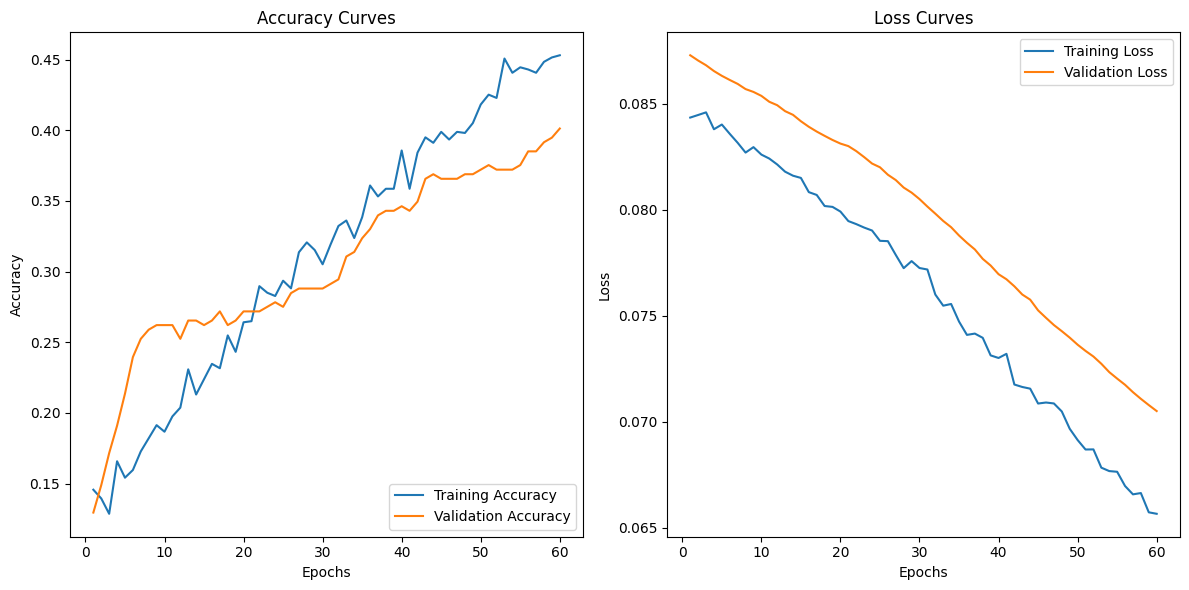

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                           precision    recall  f1-score   support

              flag_waving       0.00      0.00      0.00        45
exaggeration,minimisation       0.42      0.33      0.37        30
causal_oversimplification       0.33      0.77      0.47        35
    name_calling,labeling       0.38      0.85      0.53        34
               repetition       0.38      0.53      0.44        40
                    doubt       0.74      0.33      0.45        43
          loaded_language       0.42      0.13      0.20        39
 appeal_to_fear_prejudice       0.43      0.42      0.42        43

                 accuracy                           0.40       309
                macro avg       0.39      0.42      0.36       309
             weighted avg       0.38      0.40      0.35       309



100%|██████████| 52/52 [00:15<00:00,  3.31it/s]


Epochs: 1 | Train Loss: 0.084 | Train Accuracy: 0.116
Val loss: 0.087 | Val Accuracy: 0.152


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 2 | Train Loss: 0.084 | Train Accuracy: 0.139
Val loss: 0.087 | Val Accuracy: 0.152


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 3 | Train Loss: 0.084 | Train Accuracy: 0.131
Val loss: 0.087 | Val Accuracy: 0.152


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 4 | Train Loss: 0.084 | Train Accuracy: 0.134
Val loss: 0.087 | Val Accuracy: 0.152


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 5 | Train Loss: 0.084 | Train Accuracy: 0.125
Val loss: 0.087 | Val Accuracy: 0.152


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 6 | Train Loss: 0.084 | Train Accuracy: 0.134
Val loss: 0.087 | Val Accuracy: 0.152


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 7 | Train Loss: 0.084 | Train Accuracy: 0.136
Val loss: 0.087 | Val Accuracy: 0.149


100%|██████████| 52/52 [00:15<00:00,  3.30it/s]


Epochs: 8 | Train Loss: 0.084 | Train Accuracy: 0.131
Val loss: 0.087 | Val Accuracy: 0.149


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 9 | Train Loss: 0.084 | Train Accuracy: 0.149
Val loss: 0.087 | Val Accuracy: 0.149


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Epochs: 10 | Train Loss: 0.084 | Train Accuracy: 0.133
Val loss: 0.087 | Val Accuracy: 0.152


 23%|██▎       | 12/52 [00:03<00:12,  3.24it/s]


KeyboardInterrupt: 

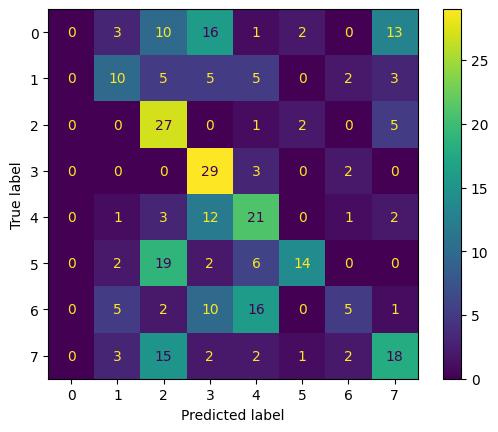

In [11]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import uuid

# lrs = [1e-6, 5e-7, 1e-7]

lrs = [5e-5, 1e-5, 5e-6]
epochs = 20
for lr in lrs:

  model=BertClassifier(num_classes=8)
  criterion=nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)


  train_acc_list = []
  train_loss_list = []
  val_acc_list = []
  val_loss_list = []

  best_val_acc = 0
  best_epoch = 0
  best_model_state = None

  model_id = str(uuid.uuid4())


  model.to(device)
  for epoch_num in range(epochs):
          total_acc_train=0
          total_loss_train=0
          model.train()
          for train_input,train_label in tqdm(train_dataloader):

              input_id,mask, train_label=prepare_inputs(train_input,train_label,device)

              output_1=model(input_id,mask)

              batch_loss_1=criterion(output_1,train_label.long())
              total_loss_train +=batch_loss_1.item()

              acc=(output_1.argmax(dim=1)==train_label).sum().item()
              total_acc_train+=acc

              model.zero_grad()
              batch_loss_1.backward()
              optimizer.step()

          total_acc_val=0
          total_loss_val=0

          y_true = []
          y_pred = []
          model.eval()
          with torch.no_grad():
              for val_input,val_label in val_dataloader:

                  input_id,mask, val_label=prepare_inputs(val_input,val_label,device)

                  output_2= model(input_id,mask)

                  # for scoring
                  predicted = output_2.argmax(dim=1)
                  y_true.extend(val_label.cpu().numpy())
                  y_pred.extend(predicted.cpu().numpy())

                  batch_loss_2=criterion(output_2,val_label.long())

                  total_loss_val+=batch_loss_2.item()

                  acc=(output_2.argmax(dim=1)==val_label).sum().item()
                  total_acc_val+=acc
              train_acc = total_acc_train / len(train_data)

          train_loss = total_loss_train / len(train_data)
          val_acc = total_acc_val / len(val_data)
          val_loss = total_loss_val / len(val_data)

          train_acc_list.append(train_acc)
          train_loss_list.append(train_loss)
          val_acc_list.append(val_acc)
          val_loss_list.append(val_loss)

          print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
          print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
          if val_acc > best_val_acc:
            best_epoch = epoch_num
            y_true_best = y_true.copy()
            y_pred_best = y_pred.copy()
            best_val_acc = val_acc
            best_model_state = model.state_dict()

          if epoch_num == epochs-1:
              print(f'______{model_id}______')
              print(f'LR: {lr} FINAL ACC = {total_acc_val / len(val_data):.3f}')
              print(f'LR: {lr} BEST ACC = {best_val_acc:.3f}')
              print('____________')


  # Plot the accuracy and loss curves over epochs
  epochs_range = range(1, epochs+1)

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_acc_list, label='Training Accuracy')
  plt.plot(epochs_range, val_acc_list, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.title('Accuracy Curves')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_loss_list, label='Training Loss')
  plt.plot(epochs_range, val_loss_list, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc='upper right')
  plt.title('Loss Curves')

  plt.tight_layout()
  plt.show()

  from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
  import matplotlib.pyplot as plt
  import numpy as np
  import seaborn as sns
  from sklearn.metrics import confusion_matrix, classification_report
  import json
  # analysis of best performing model
  classes = list(id_to_label.values())
  cm = confusion_matrix(y_true_best, y_pred_best)

  disp = ConfusionMatrixDisplay(cm)
  disp.plot()

  # Compute precision, recall, F1-score, and other metrics for the best model
  report = classification_report(y_true_best, y_pred_best, target_names=classes)
  print('Classification Report:')
  print(report)


  results_dict = {
      'model_id': model_id,
      'train_accuracy': train_acc_list,
      'train_loss': train_loss_list,
      'val_accuracy': val_acc_list,
      'val_loss': val_loss_list,
      'hyperparameters': {
          'learning_rate': lr,
          'num_epochs': epochs,
          'batch_size': batch_size,
          'max_len': max_len
      },
      'results': {
          "classes": n_classes,
          "last_acc": val_acc_list[-1],
          'best_acc': best_val_acc,
          'best_acc_epoch': best_epoch,
          'confusion_matrix': cm.tolist(),
          'classification_report': report
      }
  }


  # Save the results dictionary as a JSON file with the model ID
  results_filename = f'./results/multiclass_results_{model_id}.json'
  with open(results_filename, 'w') as f:
      json.dump(results_dict, f, indent=4)

  # Save the best model state with the model ID
  model_filename = f'./results/multiclass_best_model_{model_id}.pth'
  torch.save(best_model_state, model_filename)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json
# analysis of best performing model
classes = list(id_to_label.values())
cm = confusion_matrix(y_true_best, y_pred_best)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

# Compute precision, recall, F1-score, and other metrics for the best model
report = classification_report(y_true_best, y_pred_best, target_names=classes)
print('Classification Report:')
print(report)

In [ ]:
results_dict = {
    'model_id': model_id,
    'train_accuracy': train_acc_list,
    'train_loss': train_loss_list,
    'val_accuracy': val_acc_list,
    'val_loss': val_loss_list,
    'hyperparameters': {
        'learning_rate': lr,
        'num_epochs': epochs,
        'batch_size': batch_size,
        'max_len': max_len
    },
    'results': {
        "classes": n_classes,
        "last_acc": val_acc_list[-1],
        'best_acc': best_val_acc,
        'best_acc_epoch': best_epoch,
        'confusion_matrix': cm.tolist(),
        'classification_report': report
    }
}


# Save the results dictionary as a JSON file with the model ID
results_filename = f'./results/multiclass_results_{model_id}.json'
with open(results_filename, 'w') as f:
    json.dump(results_dict, f, indent=4)

# Save the best model state with the model ID
model_filename = f'./results/multiclass_best_model_{model_id}.pth'
torch.save(best_model_state, model_filename)